## Study Compas Dataset  
[Link](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb)

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
DATASET_PATH = os.path.join("dataset", "compas", "compas-scores.csv")

In [3]:
data = pd.read_csv(DATASET_PATH)
data.head(5)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,num_r_cases,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,is_violent_recid,num_vr_cases,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O,NaN,-1,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,NaN,13009779CF10A,F,NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,1,NaN,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,NaN,13011511MM10A,M,0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


In [4]:
data.shape

(11757, 47)

In [5]:
data.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'num_r_cases',
       'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'type_of_assessment', 'decile_score.1',
       'score_text', 'screening_date'],
      dtype='object')

In [6]:
def check_data(df, columns):
    for col in columns:
        print(col + ":")
        if not col in df.columns:
            print("Nothing found")
        else:
            print(df[col].unique())
        print()

In [7]:
check_data(data, ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']
          )

age:
[69 31 34 24 23 43 44 41 39 20 26 21 27 37 22 47 25 64 42 32 54 49 36 33
 30 63 55 29 38 53 51 28 35 48 46 62 56 45 40 59 50 66 52 71 19 61 58 78
 57 68 18 70 60 65 83 67 75 73 72 77 76 74 96 80 79 86]

c_charge_degree:
['F' 'O' 'M']

race:
['Other' 'Caucasian' 'African-American' 'Hispanic' 'Asian'
 'Native American']

age_cat:
['Greater than 45' '25 - 45' 'Less than 25']

score_text:
['Low' 'Medium' 'High' nan]

sex:
['Male' 'Female']

priors_count:
[ 0  4  1  2 14  3  7  6  5 13  8  9 15 19 21 22 20 10 12 28 11 23 25 24
 36 18 29 16 17 33 30 43 27 26 38 37 35 31 39]

decile_score:
[ 1  5  3  4  8  6 10  9  2 -1  7]

is_recid:
[ 0 -1  1]

two_year_recid:
Nothing found

c_jail_in:
['2013-08-13 06:03:42' nan '2013-01-26 03:45:27' ... '2013-05-16 08:58:35'
 '2013-05-21 03:12:58' '2014-01-10 06:49:02']

c_jail_out:
['2013-08-14 05:41:20' nan '2013-02-05 05:36:53' ... '2013-05-18 07:59:30'
 '2013-05-22 09:04:20' '2014-01-11 01:45:55']



In [8]:
# select data and preprocess
data_processed = data[(data['days_b_screening_arrest'].isnull()) | (data['days_b_screening_arrest'] <= 30)]
data_processed = data[(data['days_b_screening_arrest'].isnull()) | (data['days_b_screening_arrest'] >= -30)] # select within 30 days
data_processed.shape

(10958, 47)

In [9]:
data_processed = data_processed[data_processed['is_recid'] != -1]
data_processed = data_processed[data_processed['c_charge_degree'] != 'O']
data_processed.dropna(subset=["c_charge_desc", "c_jail_out", "c_jail_in", "days_b_screening_arrest"], inplace=True)
data_processed.shape

(9764, 47)

In [10]:
data_processed = data_processed.reset_index(drop=True)

In [11]:
data_train = data_processed[["age", "age_cat", "c_charge_degree", "priors_count", "juv_misd_count", "juv_fel_count", "juv_other_count", "c_charge_desc", "days_b_screening_arrest"]].copy()
data_train["length_of_stay"] = pd.to_datetime(data_processed["c_jail_out"]) - pd.to_datetime(data_processed["c_jail_in"])
data_train["length_of_stay"] = data_train["length_of_stay"] / pd.Timedelta(hours=1) # convert to hour base
data_target = data_processed[["is_recid"]].copy()

In [12]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9764 entries, 0 to 9763
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      9764 non-null   int64  
 1   age_cat                  9764 non-null   object 
 2   c_charge_degree          9764 non-null   object 
 3   priors_count             9764 non-null   int64  
 4   juv_misd_count           9764 non-null   int64  
 5   juv_fel_count            9764 non-null   int64  
 6   juv_other_count          9764 non-null   int64  
 7   c_charge_desc            9764 non-null   object 
 8   days_b_screening_arrest  9764 non-null   float64
 9   length_of_stay           9764 non-null   float64
dtypes: float64(2), int64(5), object(3)
memory usage: 762.9+ KB


In [13]:
data_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9764 entries, 0 to 9763
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   is_recid  9764 non-null   int64
dtypes: int64(1)
memory usage: 76.4 KB


In [14]:
data_processed["is_recid"].value_counts()

0    6363
1    3401
Name: is_recid, dtype: int64

In [15]:
data_processed["age_cat"].value_counts()

25 - 45            5577
Greater than 45    2095
Less than 25       2092
Name: age_cat, dtype: int64

In [16]:
data_processed["c_charge_degree"].value_counts()

F    6366
M    3398
Name: c_charge_degree, dtype: int64

In [17]:
data_processed["race"].value_counts()

African-American    4878
Caucasian           3371
Hispanic             855
Other                582
Asian                 48
Native American       30
Name: race, dtype: int64

In [18]:
data_processed["sex"].value_counts()

Male      7766
Female    1998
Name: sex, dtype: int64

In [19]:
data_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9764 entries, 0 to 9763
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   is_recid  9764 non-null   int64
dtypes: int64(1)
memory usage: 76.4 KB


In [20]:
# preprocessing
from sklearn.preprocessing import LabelEncoder
encoders = {}
for col in ['age_cat', 'c_charge_degree', 'c_charge_desc']:
    encoder = LabelEncoder()
    data_train[col] = encoder.fit_transform(data_train[col])
    encoders[col] = encoder
data_train.head(5)

,age,age_cat,c_charge_degree,priors_count,juv_misd_count,juv_fel_count,juv_other_count,c_charge_desc,days_b_screening_arrest,length_of_stay
0,69,1,0,0,0,0,0,18,-1.0,23.627222
1,34,0,0,0,0,0,0,187,-1.0,241.857222
2,24,2,0,4,0,0,1,349,-1.0,26.058333
3,44,0,1,0,0,0,0,54,0.0,31.643889
4,41,0,0,14,0,0,0,325,-1.0,151.168333


In [21]:
data_train.describe()

,age,age_cat,c_charge_degree,priors_count,juv_misd_count,juv_fel_count,juv_other_count,c_charge_desc,days_b_screening_arrest,length_of_stay
count,9764.000000,9764.000000,9764.000000,9764.000000,9764.000000,9764.000000,9764.000000,9764.000000,9764.000000,9764.000000
mean,34.741909,0.643077,0.348013,3.127509,0.080705,0.063294,0.099857,228.884986,7.507374,568.780862
std,11.813679,0.811239,0.476365,4.669978,0.464714,0.458554,0.468362,156.667580,63.144447,1767.560725
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-30.000000,-11.704722
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.000000,-1.000000,21.512222
50%,31.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,203.000000,-1.000000,29.833056
75%,42.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,349.000000,0.000000,213.165278
max,96.000000,2.000000,1.000000,43.000000,13.000000,20.000000,11.000000,476.000000,1057.000000,51670.880278


## Build Model  
The goal here is to build several models to predict the possibility of a person's is_recid in future  
and compare it with the decile_score and score_text output  

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
# from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [23]:
result = cross_validate(estimator=KNeighborsClassifier(),
                        X=data_train.to_numpy(), y=data_target.to_numpy().ravel(), cv=5,
                        return_estimator=True)
result_best_ids = np.argmax(result["test_score"])
model_neighbor = {
    'avg_score': result['test_score'].mean(),
    'best_estimator': result['estimator'][result_best_ids]
}
print(model_neighbor['avg_score'])

0.6441019176046939


In [24]:
result = cross_validate(estimator=LinearSVC(dual=False),
                        X=data_train.to_numpy(), y=data_target.to_numpy().ravel(), cv=5,
                        return_estimator=True)
result_best_ids = np.argmax(result["test_score"])
model_linearSVC = {
    'avg_score': result['test_score'].mean(),
    'best_estimator': result['estimator'][result_best_ids]
}
print(model_linearSVC['avg_score'])

0.6899836212468419


In [25]:
result = cross_validate(estimator=SVC(),
                        X=data_train.to_numpy(), y=data_target.to_numpy().ravel(), cv=5,
                        return_estimator=True)
result_best_ids = np.argmax(result["test_score"])
model_SVC = {
    'avg_score': result['test_score'].mean(),
    'best_estimator': result['estimator'][result_best_ids]
}
print(model_SVC['avg_score'])

0.6517821468442833


In [26]:
result = cross_validate(estimator=LogisticRegression(max_iter=10000),
                        X=data_train.to_numpy(), y=data_target.to_numpy().ravel(), cv=5,
                        return_estimator=True)
result_best_ids = np.argmax(result["test_score"])
model_logreg = {
    'avg_score': result['test_score'].mean(),
    'best_estimator': result['estimator'][result_best_ids]
}
print(model_logreg['avg_score'])

0.6898811097680744


In [27]:
result = cross_validate(estimator=RandomForestClassifier(),
                        X=data_train.to_numpy(), y=data_target.to_numpy().ravel(), cv=5,
                        return_estimator=True)
result_best_ids = np.argmax(result["test_score"])
model_forest = {
    'avg_score': result['test_score'].mean(),
    'best_estimator': result['estimator'][result_best_ids]
}
print(model_forest['avg_score'])

0.6848631361587469


## Improvement

In [28]:
# select balanced rows
idx0 = data_target[data_target["is_recid"] == 0].copy().index
idx1 = data_target[data_target["is_recid"] == 1].copy().index
idx0.shape, idx1.shape

((6363,), (3401,))

In [29]:
rnd_idx0 = idx0.to_numpy()[np.random.permutation(idx0.shape[0])][:idx1.shape[0]]
final_index = rnd_idx0.tolist() + idx1.tolist()
len(final_index)

6802

In [30]:
data_target_selected = data_target.iloc[final_index].copy()
data_target_selected.shape

(6802, 1)

In [31]:
data_target_selected[data_target_selected["is_recid"] == 0].shape

(3401, 1)

In [32]:
data_target_selected[data_target_selected["is_recid"] == 1].shape

(3401, 1)

In [33]:
data_train_selected = data_train.iloc[final_index].copy()

In [34]:
result = cross_validate(estimator=KNeighborsClassifier(),
                        X=data_train_selected.to_numpy(), y=data_target_selected.to_numpy().ravel(), cv=5,
                        return_estimator=True)
result_best_ids = np.argmax(result["test_score"])
model_neighbor_selected = {
    'avg_score': result['test_score'].mean(),
    'best_estimator': result['estimator'][result_best_ids]
}
print(model_neighbor_selected['avg_score'])

0.5952620261918139


In [35]:
result = cross_validate(estimator=LinearSVC(dual=False),
                        X=data_train_selected.to_numpy(), y=data_target_selected.to_numpy().ravel(), cv=5,
                        return_estimator=True)
result_best_ids = np.argmax(result["test_score"])
model_linearSVC_selected = {
    'avg_score': result['test_score'].mean(),
    'best_estimator': result['estimator'][result_best_ids]
}
print(model_linearSVC_selected['avg_score'])

0.6533367549811989


In [36]:
result = cross_validate(estimator=SVC(),
                        X=data_train_selected.to_numpy(), y=data_target_selected.to_numpy().ravel(), cv=5,
                        return_estimator=True)
result_best_ids = np.argmax(result["test_score"])
model_svc_selected = {
    'avg_score': result['test_score'].mean(),
    'best_estimator': result['estimator'][result_best_ids]
}
print(model_svc_selected['avg_score'])

0.5495458572848684


In [37]:
result = cross_validate(estimator=LogisticRegression(max_iter=10000),
                        X=data_train_selected.to_numpy(), y=data_target_selected.to_numpy().ravel(), cv=5,
                        return_estimator=True)
result_best_ids = np.argmax(result["test_score"])
model_logreg_selected = {
    'avg_score': result['test_score'].mean(),
    'best_estimator': result['estimator'][result_best_ids]
}
print(model_logreg_selected['avg_score'])

0.6580413407096859


In [38]:
result = cross_validate(estimator=RandomForestClassifier(),
                        X=data_train_selected.to_numpy(), y=data_target_selected.to_numpy().ravel(), cv=5,
                        return_estimator=True)
result_best_ids = np.argmax(result["test_score"])
model_forest_selected = {
    'avg_score': result['test_score'].mean(),
    'best_estimator': result['estimator'][result_best_ids]
}
print(model_forest_selected['avg_score'])

0.6484869473138264


### Try SMOTE 

In [39]:
from sklearn.model_selection import train_test_split

def test_with_smote(X, y, algo_list, smote_obj, repeat=10, test_size=0.2):
    for algo in algo_list:
        score = 0
        for _ in range(repeat):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
            X_train_res, y_train_res = smote_obj.fit_resample(X_train, y_train)
            algo.fit(X_train_res, y_train_res)
            score += algo.score(X_test, y_test)
        score /= repeat
        print("{}: {:.5f}".format(algo.__class__.__name__, score))

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
X = data_train.to_numpy()
y = data_target.to_numpy().ravel()
algo_list = [KNeighborsClassifier(), LinearSVC(dual=False), SVC(), LogisticRegression(max_iter=10000), RandomForestClassifier()]

In [42]:
X.shape, y.shape

((9764, 10), (9764,))

In [43]:
from imblearn.over_sampling import BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, ADASYN

In [44]:
test_with_smote(X, y, algo_list, BorderlineSMOTE(random_state=22))

KNeighborsClassifier: 0.58669
LinearSVC: 0.65013
SVC: 0.58070
LogisticRegression: 0.65509
RandomForestClassifier: 0.68264


In [45]:
test_with_smote(X, y, algo_list, KMeansSMOTE(cluster_balance_threshold=0.4, random_state=22))

KNeighborsClassifier: 0.63313
LinearSVC: 0.67220
SVC: 0.64496
LogisticRegression: 0.68198
RandomForestClassifier: 0.68730


In [46]:
test_with_smote(X, y, algo_list, SVMSMOTE(random_state=22))

KNeighborsClassifier: 0.60737
LinearSVC: 0.65658
SVC: 0.61930
LogisticRegression: 0.66221
RandomForestClassifier: 0.68315


In [47]:
test_with_smote(X, y, algo_list, ADASYN(random_state=22))

KNeighborsClassifier: 0.59278
LinearSVC: 0.65448
SVC: 0.59155
LogisticRegression: 0.66119
RandomForestClassifier: 0.67532


In [48]:
def test_without_smote(X, y, algo_list, repeat=10, test_size=0.2):
    for algo in algo_list:
        score = 0
        for _ in range(repeat):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
            # X_train_res, y_train_res = smote_obj.fit_resample(X_train, y_train)
            algo.fit(X_train, y_train)
            score += algo.score(X_test, y_test)
        score /= repeat
        print("{}: {:.5f}".format(algo.__class__.__name__, score))

In [49]:
test_without_smote(X, y, algo_list)

KNeighborsClassifier: 0.63825
LinearSVC: 0.69037
SVC: 0.64619
LogisticRegression: 0.69411
RandomForestClassifier: 0.68884


In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

### Add Parameter Searching

In [51]:
from sklearn.model_selection import GridSearchCV

def grid_search(X, y, model, params, smote):
    print("Model: {}".format(model.__class__.__name__))
    X_res, y_res = smote.fit_resample(X, y) # enlarge dataset
    search = GridSearchCV(model, param_grid=params, cv=10)
    search.fit(X_res, y_res)
    print("Best parameter: {}".format(search.best_params_))
    print("Acc on original data: {:.4f}".format(search.best_estimator_.score(X_test, y_test)))
    print("Acc on enlarged data: {:.4f}".format(search.best_estimator_.score(X_res, y_res)))
    return search.best_params_

#### KNN

In [52]:
knn_params = {
    "n_neighbors": [2, 5, 10, 50, 100],
}
grid_search(X_train, y_train, KNeighborsClassifier(), knn_params, BorderlineSMOTE(random_state=22))

Model: KNeighborsClassifier
Best parameter: {'n_neighbors': 2}
Acc on original data: 0.6216
Acc on enlarged data: 0.9062


{'n_neighbors': 2}

In [53]:
param_knn = grid_search(X_train, y_train, KNeighborsClassifier(), knn_params, KMeansSMOTE(cluster_balance_threshold=0.4, random_state=22))

Model: KNeighborsClassifier
Best parameter: {'n_neighbors': 2}
Acc on original data: 0.6406
Acc on enlarged data: 0.8658


In [54]:
grid_search(X_train, y_train, KNeighborsClassifier(), knn_params, SVMSMOTE(random_state=22))

Model: KNeighborsClassifier
Best parameter: {'n_neighbors': 2}
Acc on original data: 0.6272
Acc on enlarged data: 0.9038


{'n_neighbors': 2}

In [55]:
grid_search(X_train, y_train, KNeighborsClassifier(), knn_params, ADASYN(random_state=22))

Model: KNeighborsClassifier
Best parameter: {'n_neighbors': 2}
Acc on original data: 0.6144
Acc on enlarged data: 0.9145


{'n_neighbors': 2}

#### Linear SVC

In [56]:
linearsvc_params = {
    "C": [0.001, 0.01, 0.1, 1, 10],
}
grid_search(X_train, y_train, LinearSVC(dual=False), linearsvc_params, BorderlineSMOTE(random_state=22))

Model: LinearSVC
Best parameter: {'C': 10}
Acc on original data: 0.6462
Acc on enlarged data: 0.6536


{'C': 10}

In [57]:
param_linearsvc = grid_search(X_train, y_train, LinearSVC(dual=False), linearsvc_params, KMeansSMOTE(cluster_balance_threshold=0.4, random_state=22))

Model: LinearSVC
Best parameter: {'C': 0.001}
Acc on original data: 0.6641
Acc on enlarged data: 0.6814


In [58]:
grid_search(X_train, y_train, LinearSVC(dual=False), linearsvc_params, SVMSMOTE(random_state=22))

Model: LinearSVC
Best parameter: {'C': 1}
Acc on original data: 0.6385
Acc on enlarged data: 0.6733


{'C': 1}

In [59]:
grid_search(X_train, y_train, LinearSVC(dual=False), linearsvc_params, ADASYN(random_state=22))

Model: LinearSVC
Best parameter: {'C': 1}
Acc on original data: 0.6441
Acc on enlarged data: 0.6560


{'C': 1}

#### SVC

In [60]:
svc_params = {
    "C": [0.01, 0.1, 1, 10, 100],
}
grid_search(X_train, y_train, SVC(), svc_params, BorderlineSMOTE(random_state=22))

Model: SVC
Best parameter: {'C': 100}
Acc on original data: 0.6139
Acc on enlarged data: 0.6557


{'C': 100}

In [61]:
param_svc = grid_search(X_train, y_train, SVC(), svc_params, KMeansSMOTE(cluster_balance_threshold=0.4, random_state=22))

Model: SVC
Best parameter: {'C': 100}
Acc on original data: 0.6395
Acc on enlarged data: 0.7401


In [62]:
grid_search(X_train, y_train, SVC(), svc_params, SVMSMOTE(random_state=22))

Model: SVC
Best parameter: {'C': 100}
Acc on original data: 0.6436
Acc on enlarged data: 0.6802


{'C': 100}

In [63]:
grid_search(X_train, y_train, SVC(), svc_params, ADASYN(random_state=22))

Model: SVC
Best parameter: {'C': 100}
Acc on original data: 0.5904
Acc on enlarged data: 0.6498


{'C': 100}

#### Logistic Regression

In [64]:
lg_params = {
    "C": [1e-3, 1e-2, 1e-1, 1, 1e1]
}
grid_search(X_train, y_train, LogisticRegression(max_iter=10000), lg_params, BorderlineSMOTE(random_state=22))

Model: LogisticRegression
Best parameter: {'C': 0.001}
Acc on original data: 0.6462
Acc on enlarged data: 0.6605


{'C': 0.001}

In [65]:
param_logre = grid_search(X_train, y_train, LogisticRegression(max_iter=10000), lg_params, KMeansSMOTE(cluster_balance_threshold=0.4, random_state=22))

Model: LogisticRegression
Best parameter: {'C': 0.01}
Acc on original data: 0.6631
Acc on enlarged data: 0.6829


In [66]:
grid_search(X_train, y_train, LogisticRegression(max_iter=10000), lg_params, SVMSMOTE(random_state=22))

Model: LogisticRegression
Best parameter: {'C': 0.001}
Acc on original data: 0.6431
Acc on enlarged data: 0.6778


{'C': 0.001}

In [67]:
grid_search(X_train, y_train, LogisticRegression(max_iter=10000), lg_params, ADASYN(random_state=22))

Model: LogisticRegression
Best parameter: {'C': 0.001}
Acc on original data: 0.6375
Acc on enlarged data: 0.6584


{'C': 0.001}

#### Random Forest

In [68]:
forest_params = {
    "n_estimators": [5, 10, 50, 100, 200],
}
grid_search(X_train, y_train, RandomForestClassifier(), forest_params, BorderlineSMOTE(random_state=22))

Model: RandomForestClassifier
Best parameter: {'n_estimators': 100}
Acc on original data: 0.6718
Acc on enlarged data: 0.9999


{'n_estimators': 100}

In [69]:
param_forest = grid_search(X_train, y_train, RandomForestClassifier(), forest_params, KMeansSMOTE(cluster_balance_threshold=0.4, random_state=22))

Model: RandomForestClassifier
Best parameter: {'n_estimators': 200}
Acc on original data: 0.6774
Acc on enlarged data: 1.0000


In [70]:
grid_search(X_train, y_train, RandomForestClassifier(), forest_params, SVMSMOTE(random_state=22))

Model: RandomForestClassifier
Best parameter: {'n_estimators': 100}
Acc on original data: 0.6687
Acc on enlarged data: 1.0000


{'n_estimators': 100}

In [71]:
grid_search(X_train, y_train, RandomForestClassifier(), forest_params, ADASYN(random_state=22))

Model: RandomForestClassifier
Best parameter: {'n_estimators': 200}
Acc on original data: 0.6692
Acc on enlarged data: 1.0000


{'n_estimators': 200}

### Per Class Accuracy

In [72]:
def transform_cf(matrix):
    matrix = matrix.copy().astype(np.float32)
    matrix_s = matrix.sum(axis=1)
    matrix[0][0] /= matrix_s[0]
    matrix[0][1] /= matrix_s[0]
    matrix[1][0] /= matrix_s[1]
    matrix[1][1] /= matrix_s[1]
    return matrix

In [73]:
clf = RandomForestClassifier(n_estimators=param_forest['n_estimators'])
smote = KMeansSMOTE(cluster_balance_threshold=0.4, random_state=22)
X_res, y_res = smote.fit_resample(X_train, y_train)
clf.fit(X_res, y_res)
clf.score(X, y)

0.9346579270790659

In [74]:
data_train_black = X[data_processed[data_processed["race"] == "African-American"].index.tolist()]
data_train_white = X[data_processed[data_processed["race"] == "Caucasian"].index.tolist()]
data_target_black = y[data_processed[data_processed["race"] == "African-American"].index.tolist()]
data_target_white = y[data_processed[data_processed["race"] == "Caucasian"].index.tolist()]

#### Random Forest

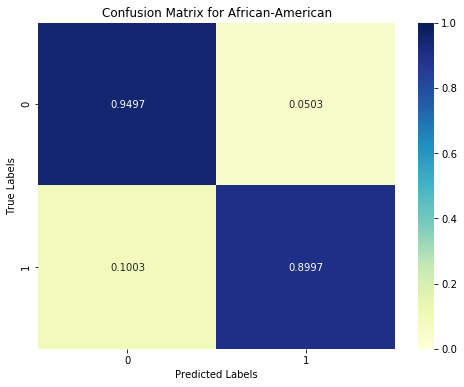

In [75]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix for African-American")
sns.heatmap(pd.DataFrame(transform_cf(confusion_matrix(data_target_black, clf.predict(data_train_black))), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", vmin=0.0, vmax=1.0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

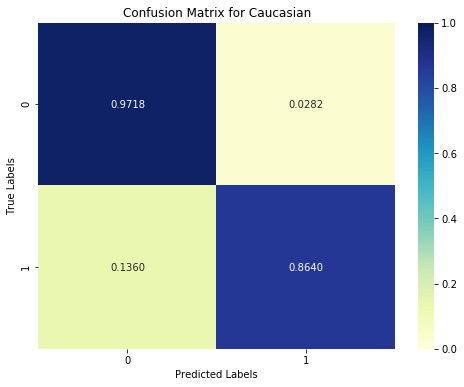

In [76]:
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix for Caucasian")
sns.heatmap(pd.DataFrame(transform_cf(confusion_matrix(data_target_white, clf.predict(data_train_white))), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", vmin=0.0, vmax=1.0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [77]:
data_train_black.shape, data_train_white.shape

((4878, 10), (3371, 10))

#### KNN

In [78]:
clf = KNeighborsClassifier(n_neighbors=param_knn['n_neighbors'])
clf.fit(X_res, y_res)
clf.score(X, y)

0.7902498975829578

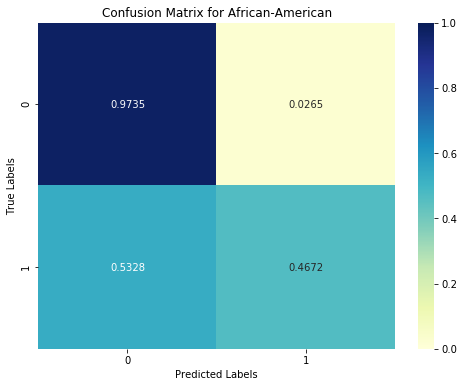

In [79]:
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix for African-American")
sns.heatmap(pd.DataFrame(transform_cf(confusion_matrix(data_target_black, clf.predict(data_train_black))), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", vmin=0.0, vmax=1.0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

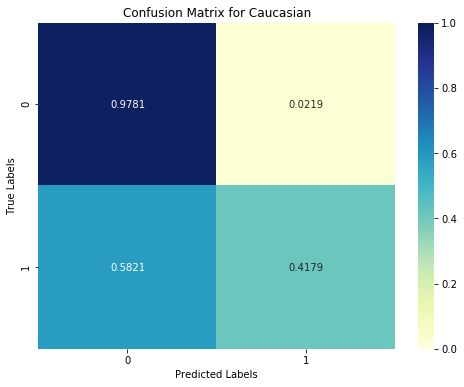

In [80]:
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix for Caucasian")
sns.heatmap(pd.DataFrame(transform_cf(confusion_matrix(data_target_white, clf.predict(data_train_white))), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", vmin=0.0, vmax=1.0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### Linear SVC

In [81]:
clf = LinearSVC(C=param_linearsvc['C'], dual=False)
clf.fit(X_res, y_res)
clf.score(X, y)

0.6763621466612044

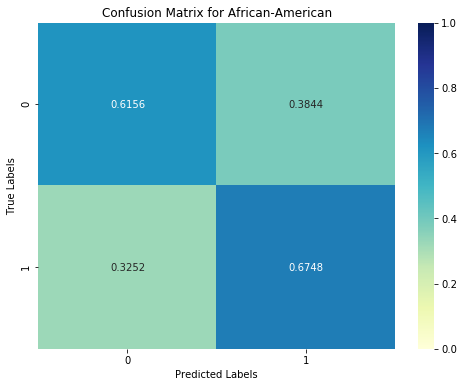

In [82]:
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix for African-American")
sns.heatmap(pd.DataFrame(transform_cf(confusion_matrix(data_target_black, clf.predict(data_train_black))), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", vmin=0.0, vmax=1.0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

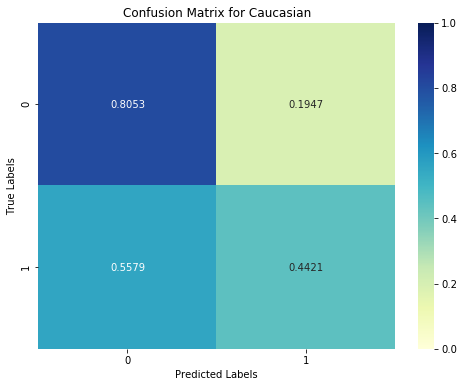

In [83]:
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix for Caucasian")
sns.heatmap(pd.DataFrame(transform_cf(confusion_matrix(data_target_white, clf.predict(data_train_white))), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", vmin=0.0, vmax=1.0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### SVC

In [84]:
clf = SVC(C=param_svc['C'])
clf.fit(X_res, y_res)
clf.score(X, y)

0.6550594018844735

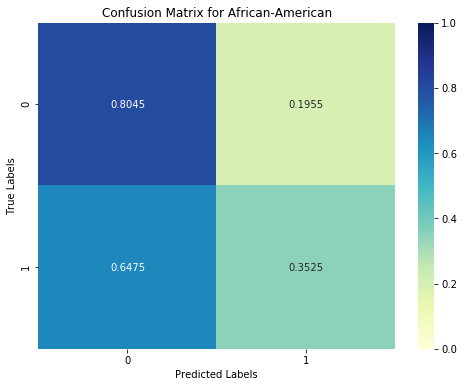

In [85]:
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix for African-American")
sns.heatmap(pd.DataFrame(transform_cf(confusion_matrix(data_target_black, clf.predict(data_train_black))), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", vmin=0.0, vmax=1.0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

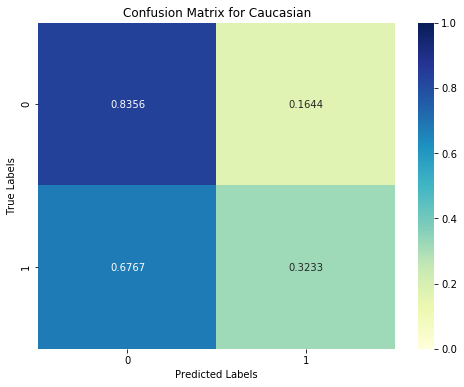

In [86]:
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix for Caucasian")
sns.heatmap(pd.DataFrame(transform_cf(confusion_matrix(data_target_white, clf.predict(data_train_white))), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", vmin=0.0, vmax=1.0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### Logistic Regression

In [87]:
clf = LogisticRegression(C=param_logre['C'], max_iter=10000)
clf.fit(X_res, y_res)
clf.score(X, y)

0.6717533797623925

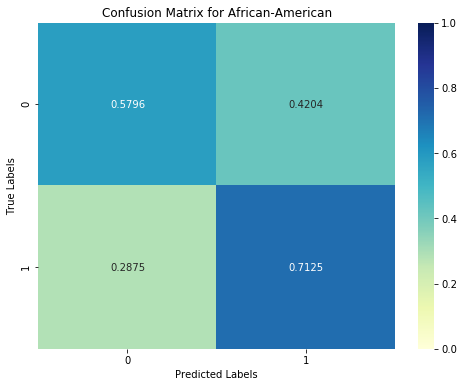

In [88]:
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix for African-American")
sns.heatmap(pd.DataFrame(transform_cf(confusion_matrix(data_target_black, clf.predict(data_train_black))), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", vmin=0.0, vmax=1.0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

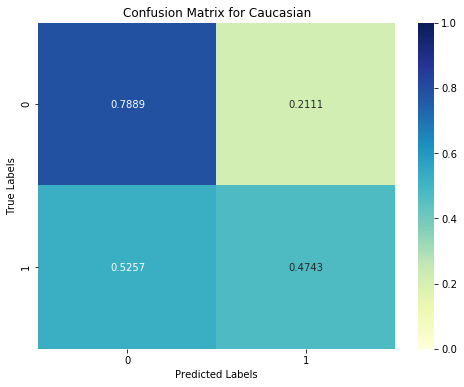

In [89]:
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix for Caucasian")
sns.heatmap(pd.DataFrame(transform_cf(confusion_matrix(data_target_white, clf.predict(data_train_white))), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", vmin=0.0, vmax=1.0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Data Imputation

In [90]:
from utils.data import Dataset, create_compas_dataset
from utils.completer import complete_by_mean_col, complete_by_most_freq, complete_by_value, complete_by_nearby_row, complete_by_similar_row, complete_by_multi

In [91]:
data_compas = create_compas_dataset()
data_compas.X.head(10)

,age,age_cat,c_charge_degree,priors_count,juv_misd_count,juv_fel_count,juv_other_count,c_charge_desc,days_b_screening_arrest,sex,race,length_of_stay
0,69,1,0,0,0,0,0,20.0,-1.0,Male,Other,23.627222
1,34,0,0,0,0,0,0,193.0,-1.0,Male,African-American,241.857222
2,24,2,0,4,0,0,1,354.0,-1.0,Male,African-American,26.058333
3,23,2,0,1,1,0,0,353.0,NaN,Male,African-American,NaN
4,43,0,0,2,0,0,0,481.0,NaN,Male,Other,NaN
5,44,0,1,0,0,0,0,55.0,0.0,Male,Other,31.643889
6,41,0,0,14,0,0,0,331.0,-1.0,Male,Caucasian,151.168333
7,43,0,0,3,0,0,0,481.0,-1.0,Male,Other,23.780556
8,39,0,1,0,0,0,0,55.0,-1.0,Female,Caucasian,70.886667
9,20,2,0,0,0,0,1,336.0,-1.0,Male,Caucasian,795.975556


In [92]:
data_compas.X.shape, data_compas.y.shape

((9823, 12), (9823,))

In [93]:
data_compas.X.isnull().sum(axis=0)

age                          0
age_cat                      0
c_charge_degree              0
priors_count                 0
juv_misd_count               0
juv_fel_count                0
juv_other_count              0
c_charge_desc                4
days_b_screening_arrest    435
sex                          0
race                         0
length_of_stay             435
dtype: int64

In [94]:
def helper_freq(array):
    """simple helper function to return the most frequent number in an array"""
    count = np.bincount(array)
    return array[np.argmax(count)]

def test_complete_dataset(data_complete_x, data_complete_y, protected_features, multi=False):
    smote = KMeansSMOTE(cluster_balance_threshold=0.4, random_state=22)
    if multi: # if multiple imputation
        data_train_black = [m[m["race"] == "African-American"].drop(columns=protected_features) for m in data_complete_x]
        data_train_white = [m[m["race"] == "Caucasian"].drop(columns=protected_features) for m in data_complete_x]
        data_complete_x_0 = data_complete_x[0]
        data_target_black = data_complete_y[data_complete_x_0[data_complete_x_0["race"] == "African-American"].index.tolist()]
        data_target_white = data_complete_y[data_complete_x_0[data_complete_x_0["race"] == "Caucasian"].index.tolist()]
        data_batch = [train_test_split(m.drop(columns=protected_features), data_complete_y, test_size=0.2, random_state=22) for m in data_complete_x]
        data_res_batch = [smote.fit_resample(m[0], m[2]) for m in data_batch]
    else:
        data_train_black = data_complete_x[data_complete_x["race"] == "African-American"].drop(columns=protected_features)
        data_train_white = data_complete_x[data_complete_x["race"] == "Caucasian"].drop(columns=protected_features)
        data_target_black = data_complete_y[data_complete_x[data_complete_x["race"] == "African-American"].index.tolist()]
        data_target_white = data_complete_y[data_complete_x[data_complete_x["race"] == "Caucasian"].index.tolist()]
        X_train, X_test, y_train, y_test = train_test_split(data_complete_x.drop(columns=protected_features), data_complete_y, test_size=0.2, random_state=22)
        X_res, y_res = smote.fit_resample(X_train, y_train)
    clfs = {
        "Random Forest": RandomForestClassifier(n_estimators=param_forest['n_estimators']),
        "KNN": KNeighborsClassifier(n_neighbors=param_knn['n_neighbors']),
        "Linear SVC": LinearSVC(C=param_linearsvc['C'], dual=False),
        "SVC": SVC(C=param_svc['C']),
        "Logistic Regression": LogisticRegression(C=param_logre['C'], max_iter=10000),
    }
    for clf_name, clf in clfs.items():
        fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))
        ax = fig.add_subplot(111, frameon=False)
        fig.patch.set_alpha(1.0)
        fig.suptitle(clf_name)
        if multi:
            predicted_black = []
            predicted_white = []
            scores = []
            scores_res = []
            for (orig, res, dd_black, dd_white) in zip(data_batch, data_res_batch, data_train_black, data_train_white):
                clf.fit(res[0], res[1])
                scores.append(clf.score(orig[1], orig[3]))
                scores_res.append(clf.score(res[0], res[1]))
                predicted_black.append(clf.predict(dd_black))
                predicted_white.append(clf.predict(dd_white))
            scores = sum(scores) / len(scores)
            scores_res = sum(scores_res) / len(scores_res)
            print("{} acc: {:.5f} on test, {:.5f} on train".format(clf_name, scores, scores_res))
            predicted_black = np.array(predicted_black)
            predicted_white = np.array(predicted_white)
            predicted_black = np.apply_along_axis(helper_freq, 0, predicted_black) # get most frequent outputs
            predicted_white = np.apply_along_axis(helper_freq, 0, predicted_white)
        else:
            clf.fit(X_res, y_res)
            print("{} acc: {:.5f} on test, {:.5f} on train".format(clf_name, clf.score(X_test, y_test), clf.score(X_res, y_res)))
            predicted_black = clf.predict(data_train_black)
            predicted_white = clf.predict(data_train_white)
        conf_black = confusion_matrix(data_target_black, predicted_black)
        conf_white = confusion_matrix(data_target_white, predicted_white)
        tn, fp, fn, tp = conf_black.ravel()
        print("African-American: TN = {} FP = {} FN = {} TP = {} | FP / FN = {}".format(tn, fp, fn, tp, fp / fn))
        tn, fp, fn, tp = conf_white.ravel()
        print("Caucasian       : TN = {} FP = {} FN = {} TP = {} | FP / FN = {}".format(tn, fp, fn, tp, fp / fn))
        sns.heatmap(pd.DataFrame(transform_cf(conf_black), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", ax=ax1, vmin=0.0, vmax=1.0)
        sns.heatmap(pd.DataFrame(transform_cf(conf_white), index=[0, 1], columns=[0, 1]), annot=True, cmap="YlGnBu", fmt=".4f", ax=ax2, vmin=0.0, vmax=1.0)
        ax1.set_title("Confusion Matrix for African-American")
        ax2.set_title("Confusion Matrix for Caucasian")
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
    plt.show()

## Comparison 1: Imputation on existing missing values

#### For Comparison

In [95]:
data_compas_complete = data_compas.copy()
tmp_concat = pd.concat([data_compas_complete.X, pd.DataFrame(data_compas_complete.y, columns=["_TARGET_"])], axis=1)
tmp_concat.dropna(inplace=True)
tmp_concat.reset_index(drop=True, inplace=True)
data_compas_complete.X = tmp_concat.drop(columns=["_TARGET_"]).copy()
data_compas_complete.y = tmp_concat["_TARGET_"].to_numpy().ravel()

Random Forest acc: 0.67981 on test, 1.00000 on train
African-American: TN = 2627 FP = 152 FN = 196 TP = 1695 | FP / FN = 0.7755102040816326
Caucasian       : TN = 2261 FP = 60 FN = 121 TP = 809 | FP / FN = 0.49586776859504134
KNN acc: 0.66383 on test, 0.86368 on train
African-American: TN = 2693 FP = 86 FN = 1025 TP = 866 | FP / FN = 0.08390243902439025
Caucasian       : TN = 2270 FP = 51 FN = 571 TP = 359 | FP / FN = 0.0893169877408056
Linear SVC acc: 0.66809 on test, 0.68321 on train
African-American: TN = 1806 FP = 973 FN = 705 TP = 1186 | FP / FN = 1.3801418439716313
Caucasian       : TN = 1902 FP = 419 FN = 571 TP = 359 | FP / FN = 0.7338003502626971
SVC acc: 0.65477 on test, 0.74357 on train
African-American: TN = 2348 FP = 431 FN = 1358 TP = 533 | FP / FN = 0.3173784977908689
Caucasian       : TN = 2033 FP = 288 FN = 704 TP = 226 | FP / FN = 0.4090909090909091
Logistic Regression acc: 0.64944 on test, 0.68503 on train
African-American: TN = 1680 FP = 1099 FN = 624 TP = 1267 | FP

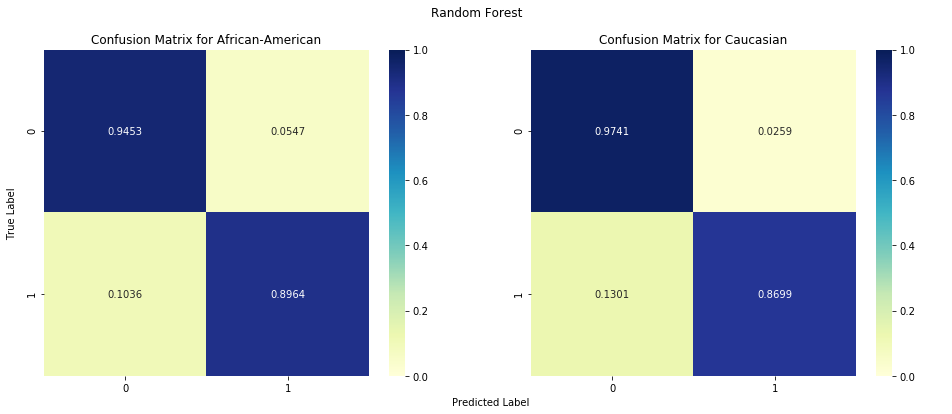

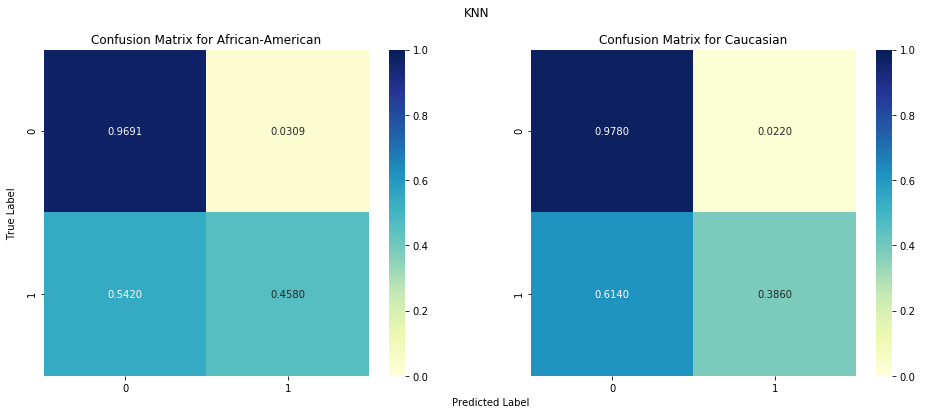

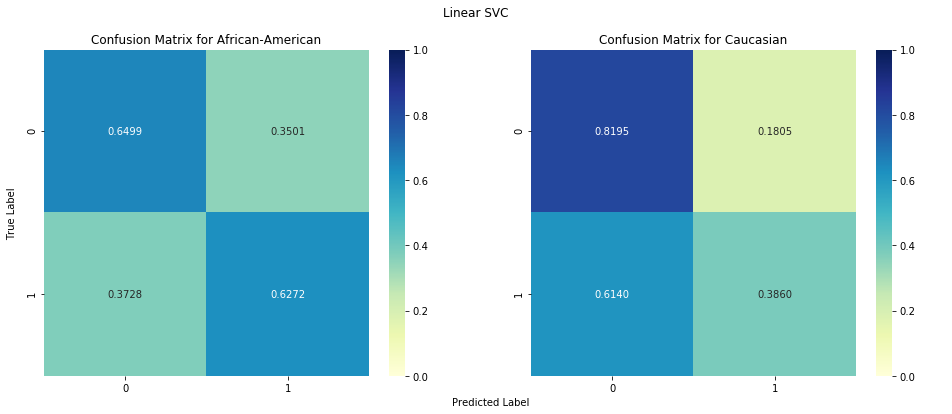

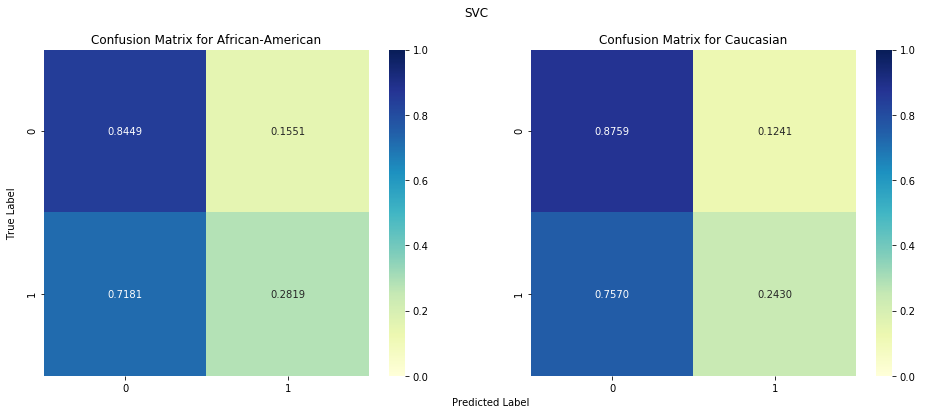

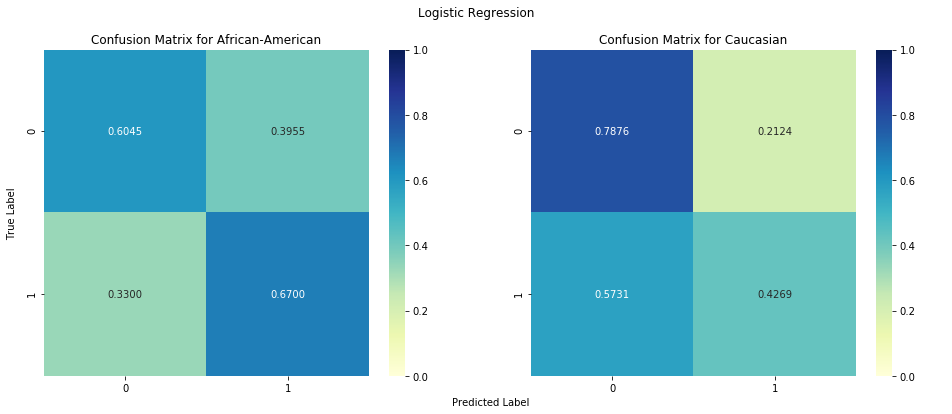

In [96]:
test_complete_dataset(data_compas_complete.X.copy(), data_compas_complete.y.copy(), data_compas_complete.protected)

#### Fill by Mean Col

In [97]:
data_compas_complete = complete_by_mean_col(data_compas)
data_compas_complete.X.isnull().sum(axis=0)

age                        0
age_cat                    0
c_charge_degree            0
priors_count               0
juv_misd_count             0
juv_fel_count              0
juv_other_count            0
c_charge_desc              0
days_b_screening_arrest    0
length_of_stay             0
race                       0
sex                        0
dtype: int64

Random Forest acc: 0.69262 on test, 1.00000 on train
African-American: TN = 2858 FP = 129 FN = 200 TP = 1724 | FP / FN = 0.645
Caucasian       : TN = 2370 FP = 56 FN = 143 TP = 792 | FP / FN = 0.3916083916083916
KNN acc: 0.64835 on test, 0.86154 on train
African-American: TN = 2917 FP = 70 FN = 1139 TP = 785 | FP / FN = 0.061457418788410885
Caucasian       : TN = 2386 FP = 40 FN = 637 TP = 298 | FP / FN = 0.06279434850863422
Linear SVC acc: 0.67074 on test, 0.70381 on train
African-American: TN = 1988 FP = 999 FN = 762 TP = 1162 | FP / FN = 1.311023622047244
Caucasian       : TN = 2030 FP = 396 FN = 597 TP = 338 | FP / FN = 0.6633165829145728
SVC acc: 0.67430 on test, 0.76165 on train
African-American: TN = 2726 FP = 261 FN = 1581 TP = 343 | FP / FN = 0.1650853889943074
Caucasian       : TN = 2308 FP = 118 FN = 824 TP = 111 | FP / FN = 0.14320388349514562
Logistic Regression acc: 0.67379 on test, 0.70504 on train
African-American: TN = 1991 FP = 996 FN = 779 TP = 1145 | FP / FN = 1.278

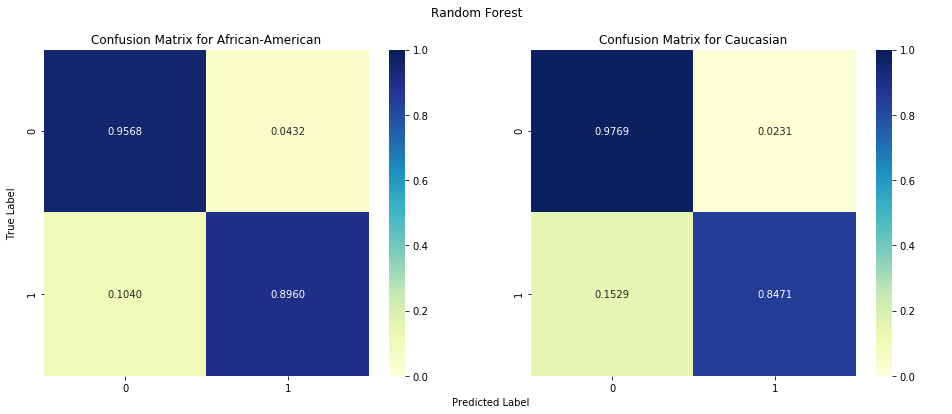

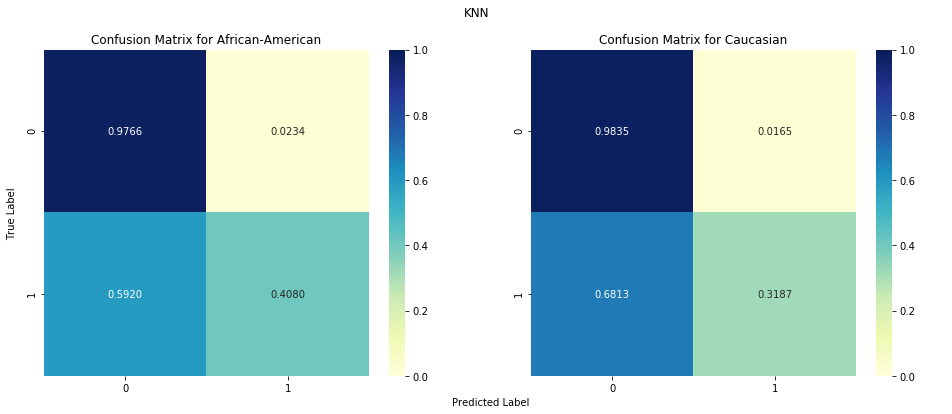

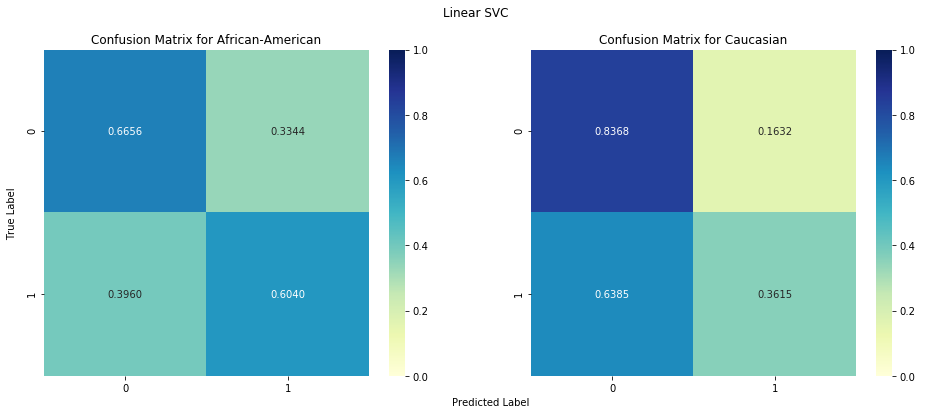

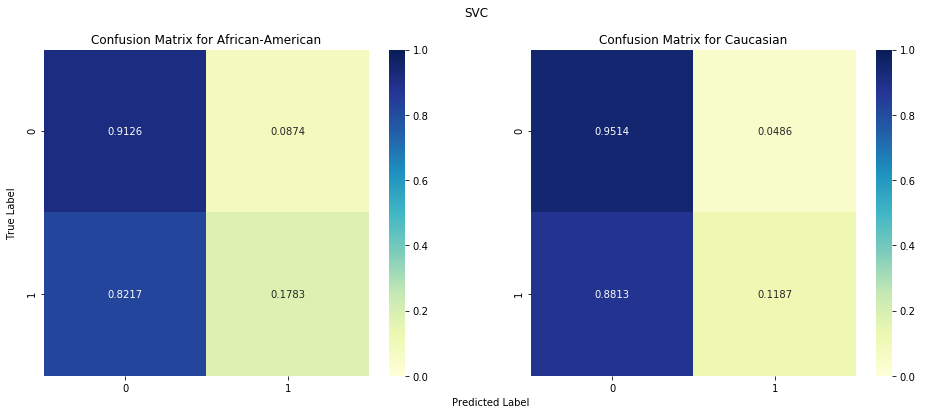

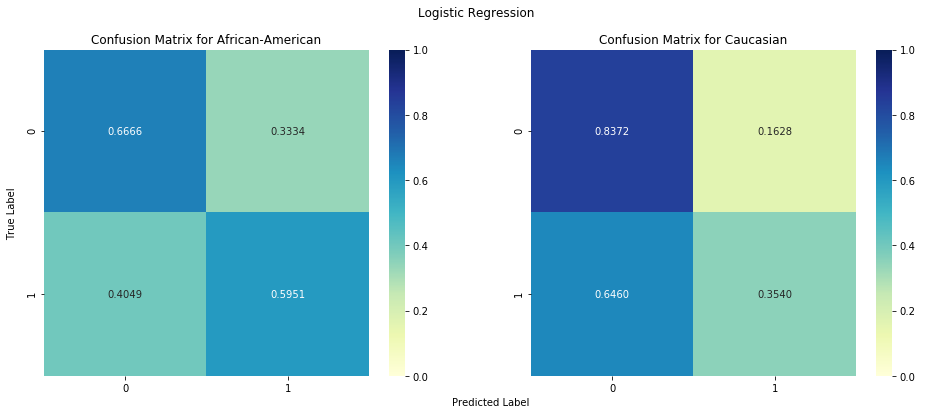

In [98]:
test_complete_dataset(data_compas_complete.X.copy(), data_compas_complete.y.copy(), data_compas_complete.protected)

#### Fill by Similar Rows

In [99]:
data_compas_complete = complete_by_similar_row(data_compas)
data_compas_complete.X.isnull().sum(axis=0)

age                        0
age_cat                    0
c_charge_degree            0
priors_count               0
juv_misd_count             0
juv_fel_count              0
juv_other_count            0
c_charge_desc              0
days_b_screening_arrest    0
length_of_stay             0
race                       0
sex                        0
dtype: int64

Random Forest acc: 0.68702 on test, 1.00000 on train
African-American: TN = 2858 FP = 129 FN = 201 TP = 1723 | FP / FN = 0.6417910447761194
Caucasian       : TN = 2362 FP = 64 FN = 142 TP = 793 | FP / FN = 0.4507042253521127
KNN acc: 0.63562 on test, 0.86871 on train
African-American: TN = 2908 FP = 79 FN = 1095 TP = 829 | FP / FN = 0.07214611872146119
Caucasian       : TN = 2374 FP = 52 FN = 609 TP = 326 | FP / FN = 0.08538587848932677
Linear SVC acc: 0.66768 on test, 0.68166 on train
African-American: TN = 1848 FP = 1139 FN = 639 TP = 1285 | FP / FN = 1.782472613458529
Caucasian       : TN = 1983 FP = 443 FN = 548 TP = 387 | FP / FN = 0.8083941605839416
SVC acc: 0.65802 on test, 0.75057 on train
African-American: TN = 2539 FP = 448 FN = 1417 TP = 507 | FP / FN = 0.31616090331686664
Caucasian       : TN = 2137 FP = 289 FN = 733 TP = 202 | FP / FN = 0.3942701227830832
Logistic Regression acc: 0.66310 on test, 0.68582 on train
African-American: TN = 1771 FP = 1216 FN = 575 TP = 1349 | F

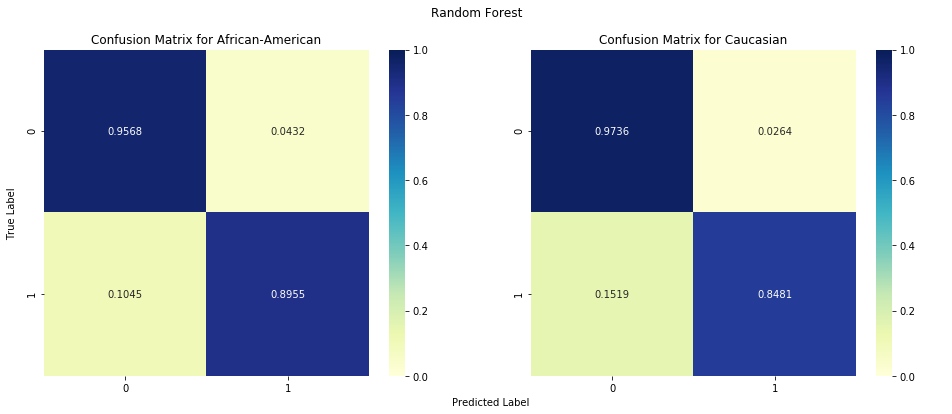

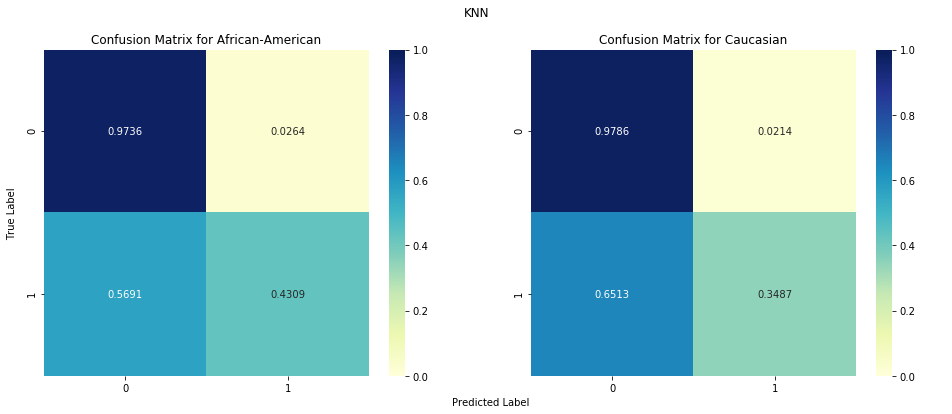

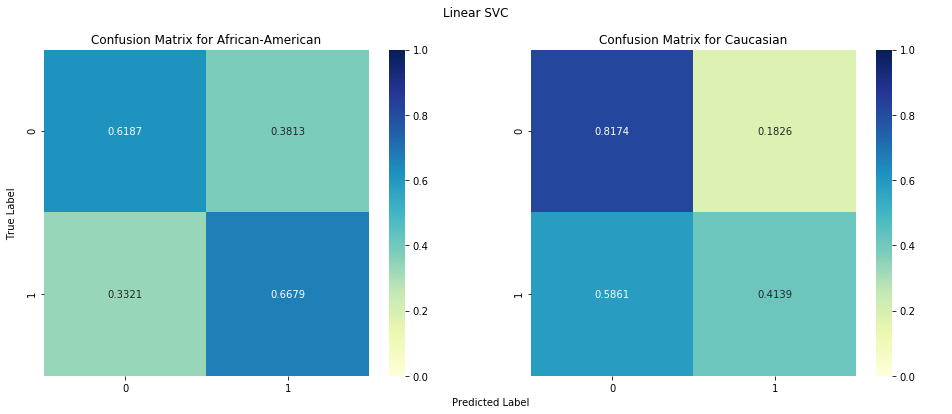

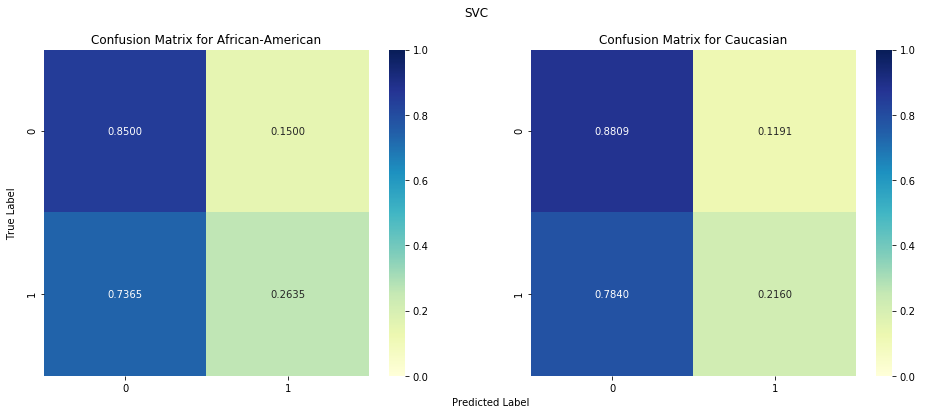

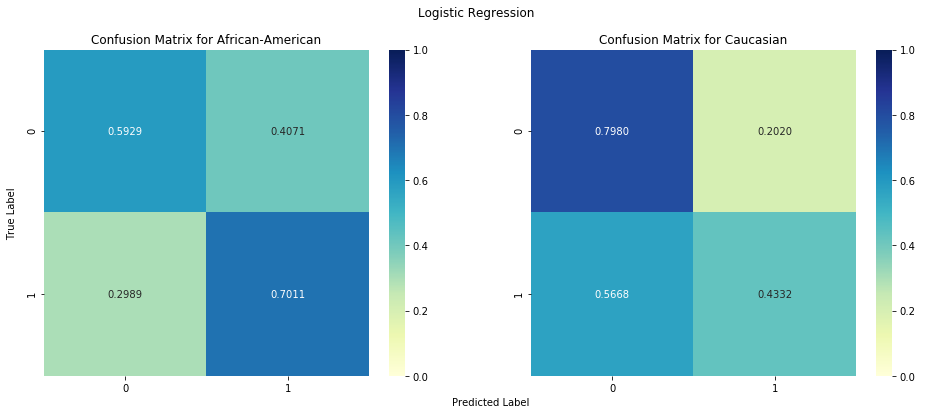

In [100]:
test_complete_dataset(data_compas_complete.X.copy(), data_compas_complete.y.copy(), data_compas_complete.protected)

#### Fill by Multiple Imputation

In [101]:
data_compas_complete_batch = complete_by_multi(data_compas)
data_compas_complete_X = [m.X.copy() for m in data_compas_complete_batch]
data_compas_complete_y = data_compas_complete_batch[0].y.copy()
data_compas_complete_protected = data_compas_complete_batch[0].protected
print("Number of imputed datasets: {}".format(len(data_compas_complete_batch)))

Number of imputed datasets: 5


Random Forest acc: 0.69181 on test, 1.00000 on train
African-American: TN = 2865 FP = 122 FN = 203 TP = 1721 | FP / FN = 0.6009852216748769
Caucasian       : TN = 2368 FP = 58 FN = 144 TP = 791 | FP / FN = 0.4027777777777778
KNN acc: 0.64204 on test, 0.86894 on train
African-American: TN = 2906 FP = 81 FN = 1068 TP = 856 | FP / FN = 0.07584269662921349
Caucasian       : TN = 2370 FP = 56 FN = 577 TP = 358 | FP / FN = 0.09705372616984402
Linear SVC acc: 0.66361 on test, 0.68127 on train
African-American: TN = 1711 FP = 1276 FN = 557 TP = 1367 | FP / FN = 2.2908438061041294
Caucasian       : TN = 1896 FP = 530 FN = 505 TP = 430 | FP / FN = 1.0495049504950495
SVC acc: 0.66076 on test, 0.75074 on train
African-American: TN = 2459 FP = 528 FN = 1323 TP = 601 | FP / FN = 0.39909297052154197
Caucasian       : TN = 2067 FP = 359 FN = 678 TP = 257 | FP / FN = 0.5294985250737463
Logistic Regression acc: 0.66290 on test, 0.68416 on train
African-American: TN = 1728 FP = 1259 FN = 558 TP = 1366 | 

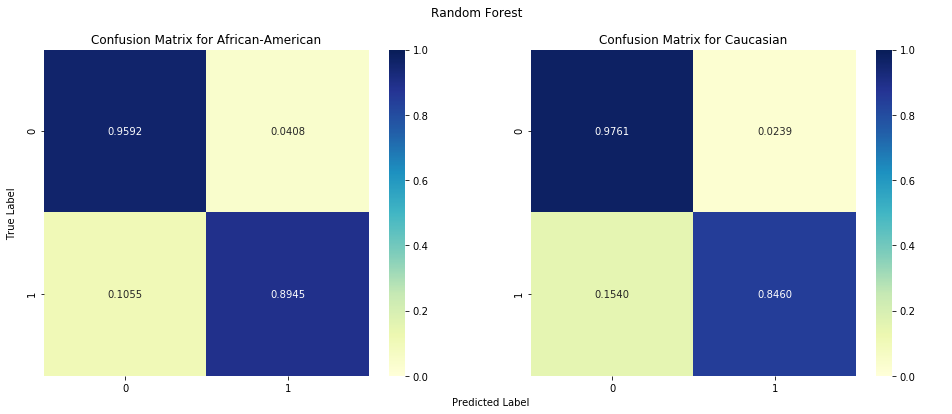

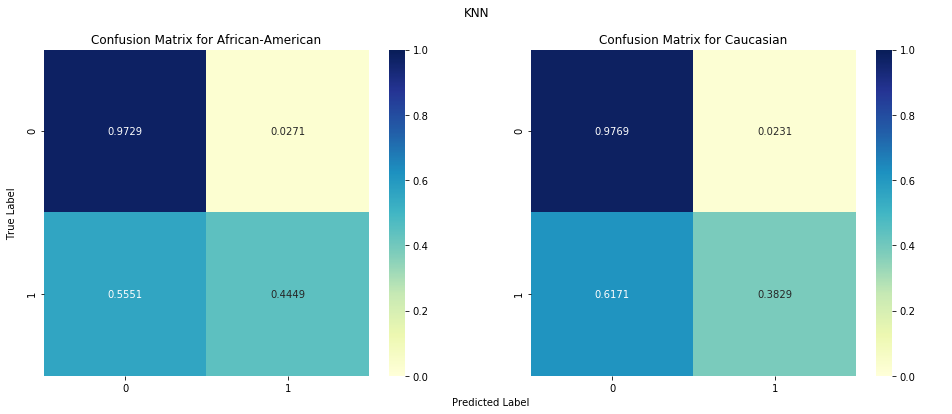

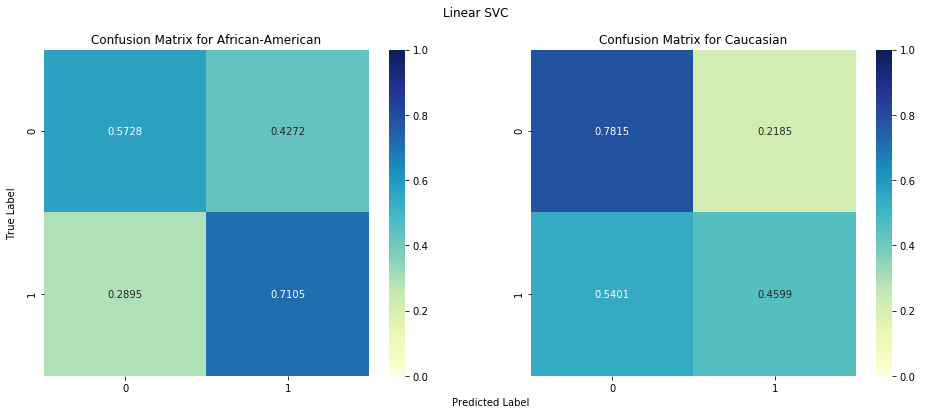

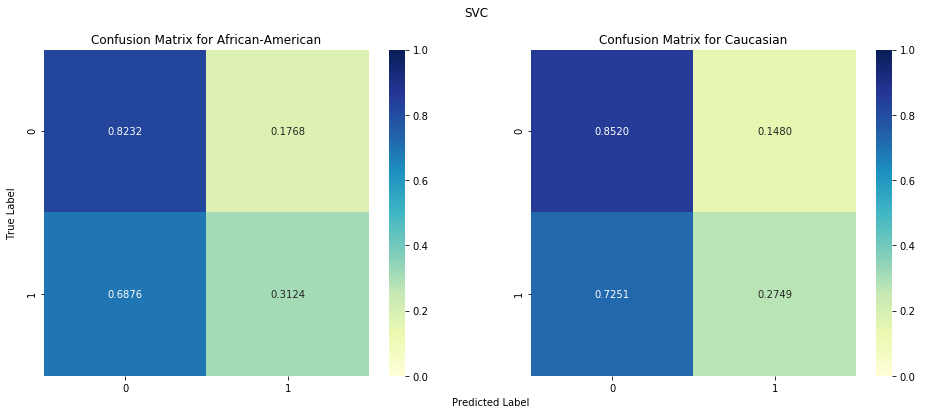

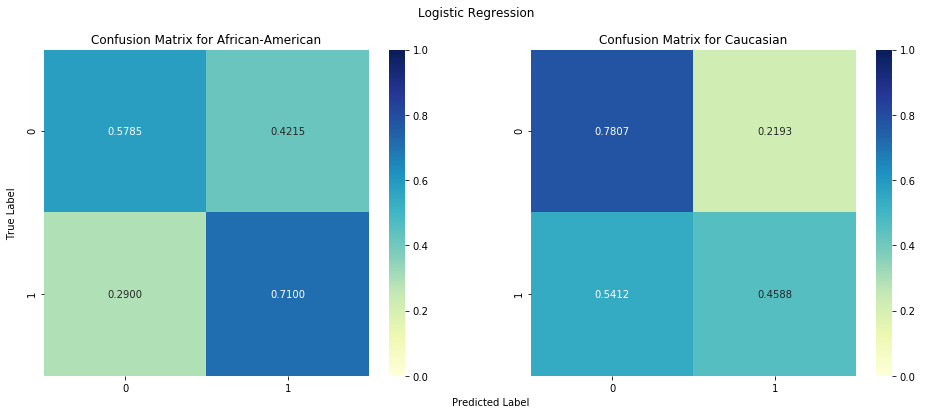

In [102]:
test_complete_dataset(data_compas_complete_X, data_compas_complete_y, data_compas_complete_protected, multi=True)

## Comparison 2: Imputation on simulated missing values

In [103]:
# first remove existing missing values
data_compas_complete = data_compas.copy()
tmp_concat = pd.concat([data_compas_complete.X, pd.DataFrame(data_compas_complete.y, columns=["_TARGET_"])], axis=1)
tmp_concat.dropna(inplace=True)
tmp_concat.reset_index(drop=True, inplace=True)
data_compas_complete.X = tmp_concat.drop(columns=["_TARGET_"]).copy()
data_compas_complete.y = tmp_concat["_TARGET_"].to_numpy().ravel()

In [105]:
# generate random missing values
from utils.generator import gen_complete_random
data_compas_incomplete = gen_complete_random(data_compas_complete, random_ratio=0.2)
data_compas_incomplete.X.isnull().sum(axis=0)

gen_complete_random: 20980 NaN values have been inserted


age                        1722
age_cat                    1734
c_charge_degree            1752
priors_count               1732
juv_misd_count             1790
juv_fel_count              1732
juv_other_count            1781
c_charge_desc              1707
days_b_screening_arrest    1652
sex                        1758
race                       1806
length_of_stay             1814
dtype: int64

#### Fill by Mean Col

Random Forest acc: 0.66542 on test, 0.99352 on train
African-American: TN = 2121 FP = 115 FN = 190 TP = 1330 | FP / FN = 0.6052631578947368
Caucasian       : TN = 1798 FP = 55 FN = 124 TP = 643 | FP / FN = 0.4435483870967742
KNN acc: 0.64518 on test, 0.84758 on train
African-American: TN = 2171 FP = 65 FN = 907 TP = 613 | FP / FN = 0.07166482910694598
Caucasian       : TN = 1812 FP = 41 FN = 523 TP = 244 | FP / FN = 0.07839388145315487
Linear SVC acc: 0.63932 on test, 0.69151 on train
African-American: TN = 1395 FP = 841 FN = 609 TP = 911 | FP / FN = 1.380952380952381
Caucasian       : TN = 1458 FP = 395 FN = 471 TP = 296 | FP / FN = 0.8386411889596603
SVC acc: 0.67128 on test, 0.74499 on train
African-American: TN = 2074 FP = 162 FN = 1296 TP = 224 | FP / FN = 0.125
Caucasian       : TN = 1764 FP = 89 FN = 685 TP = 82 | FP / FN = 0.12992700729927006
Logistic Regression acc: 0.61534 on test, 0.69182 on train
African-American: TN = 1298 FP = 938 FN = 533 TP = 987 | FP / FN = 1.759849906

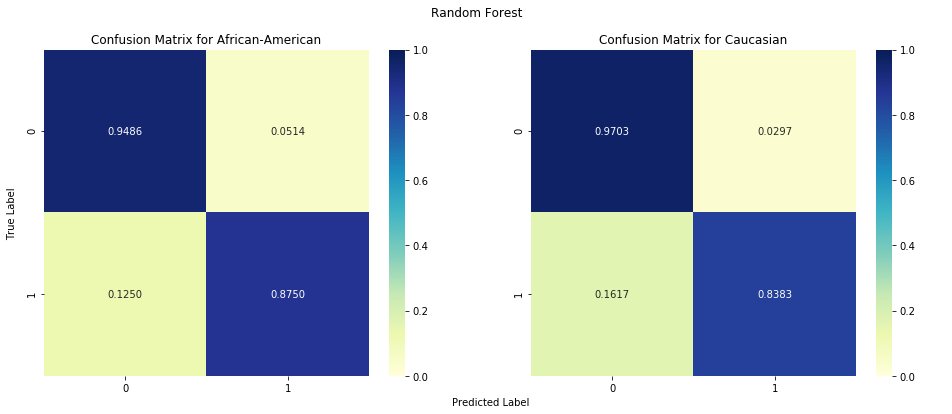

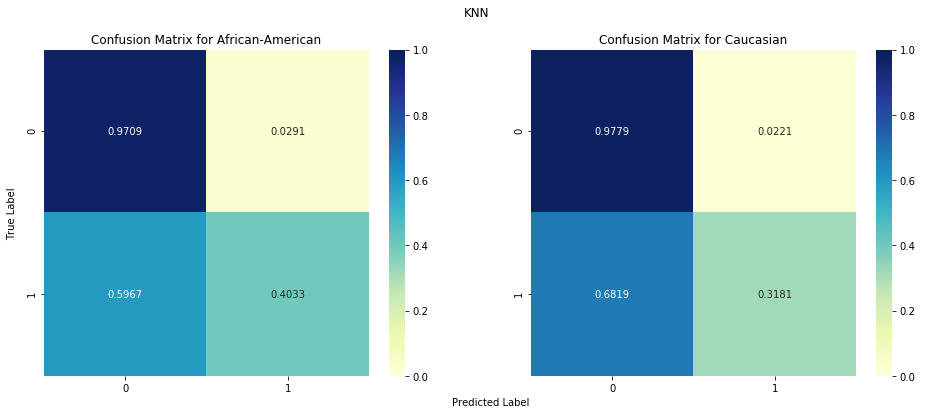

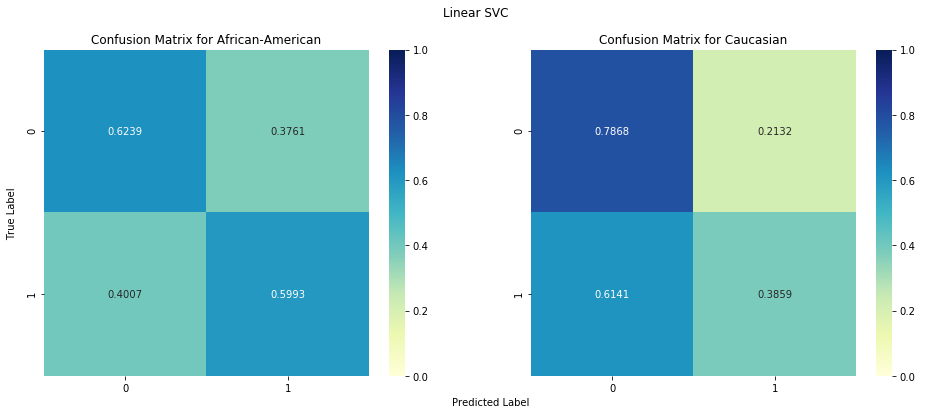

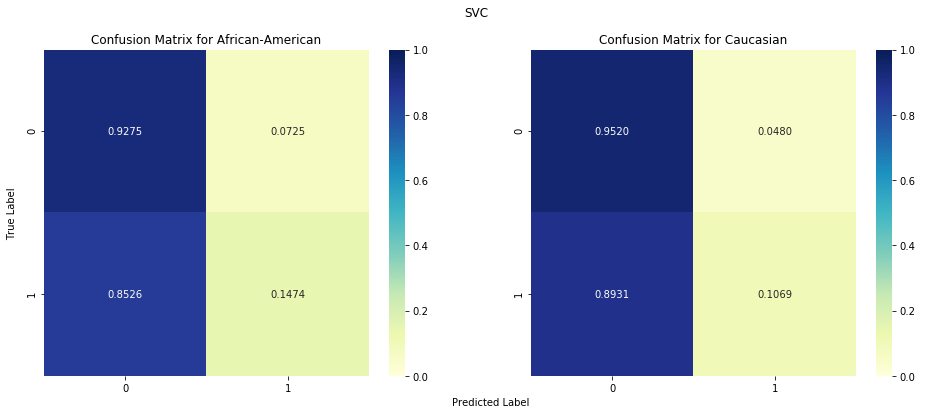

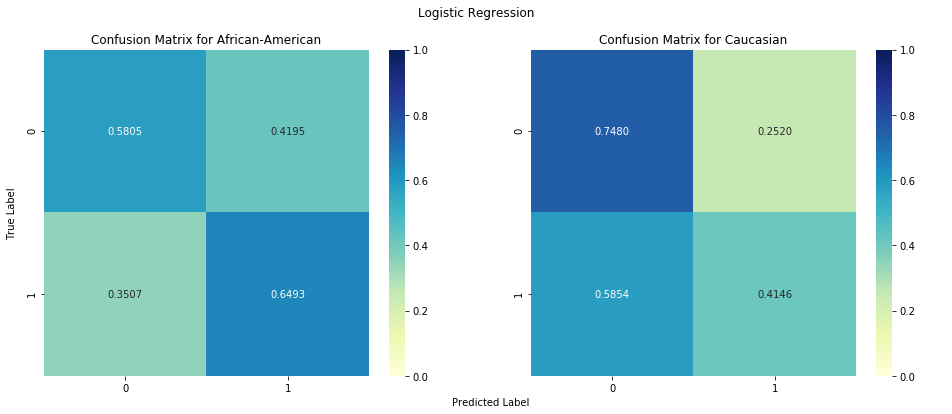

In [106]:
data_compas_complete = complete_by_mean_col(data_compas_incomplete)
test_complete_dataset(data_compas_complete.X.copy(), data_compas_complete.y.copy(), data_compas_complete.protected)

#### Fill by Similar Rows

Random Forest acc: 0.66809 on test, 0.99899 on train
African-American: TN = 2125 FP = 111 FN = 171 TP = 1349 | FP / FN = 0.6491228070175439
Caucasian       : TN = 1799 FP = 54 FN = 112 TP = 655 | FP / FN = 0.48214285714285715
KNN acc: 0.63133 on test, 0.85973 on train
African-American: TN = 2154 FP = 82 FN = 850 TP = 670 | FP / FN = 0.09647058823529411
Caucasian       : TN = 1807 FP = 46 FN = 498 TP = 269 | FP / FN = 0.09236947791164658
Linear SVC acc: 0.65903 on test, 0.66700 on train
African-American: TN = 1419 FP = 817 FN = 583 TP = 937 | FP / FN = 1.4013722126929673
Caucasian       : TN = 1490 FP = 363 FN = 474 TP = 293 | FP / FN = 0.7658227848101266
SVC acc: 0.63665 on test, 0.72564 on train
African-American: TN = 1903 FP = 333 FN = 1158 TP = 362 | FP / FN = 0.28756476683937826
Caucasian       : TN = 1607 FP = 246 FN = 597 TP = 170 | FP / FN = 0.4120603015075377
Logistic Regression acc: 0.66329 on test, 0.66974 on train
African-American: TN = 1435 FP = 801 FN = 571 TP = 949 | FP /

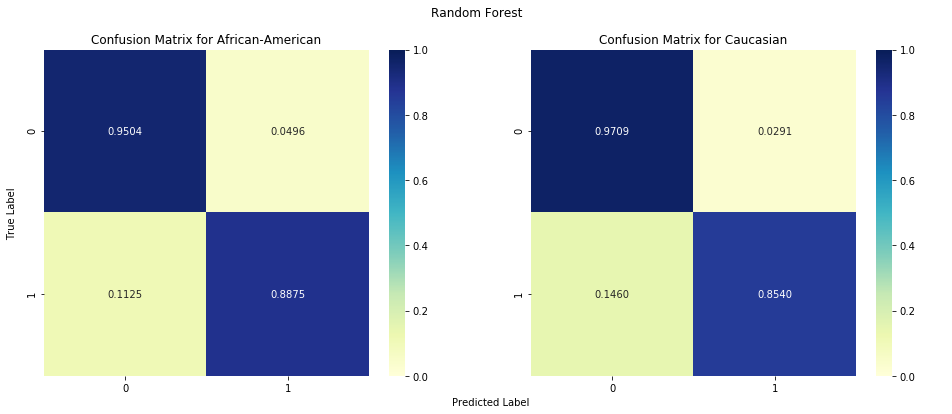

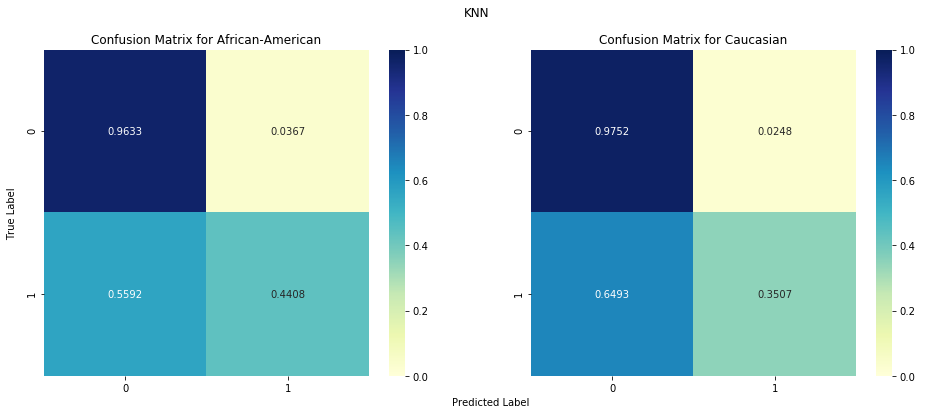

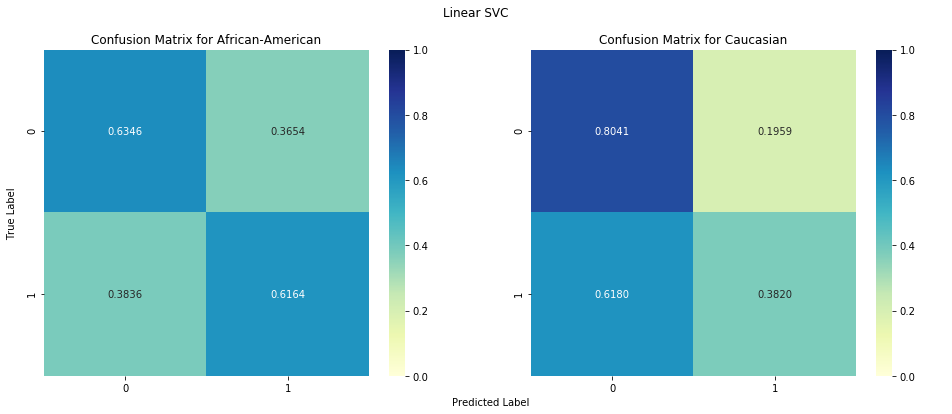

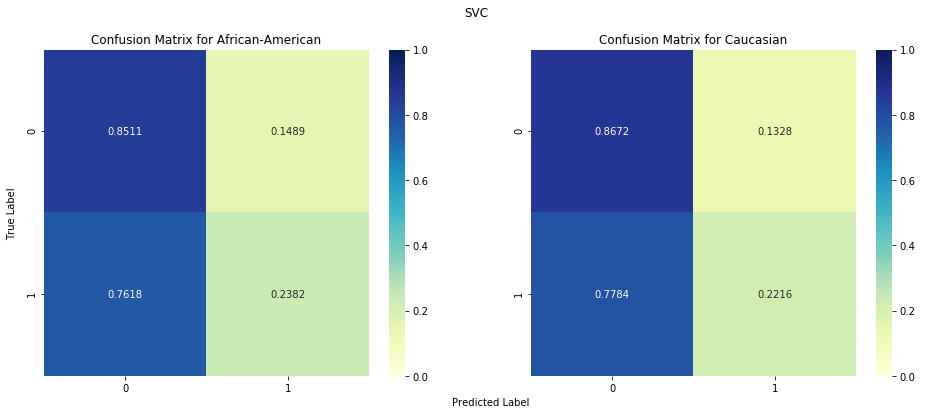

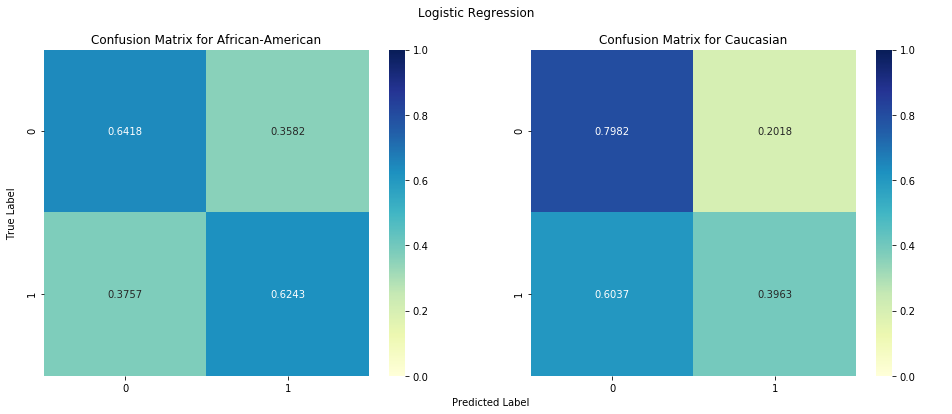

In [107]:
data_compas_complete = complete_by_similar_row(data_compas_incomplete)
test_complete_dataset(data_compas_complete.X.copy(), data_compas_complete.y.copy(), data_compas_complete.protected)

#### Fill by Multiple Imputation

In [108]:
data_compas_complete_batch = complete_by_multi(data_compas_incomplete)
data_compas_complete_X = [m.X.copy() for m in data_compas_complete_batch]
data_compas_complete_y = data_compas_complete_batch[0].y.copy()
data_compas_complete_protected = data_compas_complete_batch[0].protected
print("Number of imputed datasets: {}".format(len(data_compas_complete_batch)))

Number of imputed datasets: 5


Random Forest acc: 0.67320 on test, 1.00000 on train
African-American: TN = 2138 FP = 98 FN = 175 TP = 1345 | FP / FN = 0.56
Caucasian       : TN = 1801 FP = 52 FN = 110 TP = 657 | FP / FN = 0.4727272727272727
KNN acc: 0.64188 on test, 0.86211 on train
African-American: TN = 2175 FP = 61 FN = 862 TP = 658 | FP / FN = 0.07076566125290024
Caucasian       : TN = 1802 FP = 51 FN = 488 TP = 279 | FP / FN = 0.10450819672131148
Linear SVC acc: 0.63751 on test, 0.65125 on train
African-American: TN = 1359 FP = 877 FN = 541 TP = 979 | FP / FN = 1.6210720887245842
Caucasian       : TN = 1449 FP = 404 FN = 456 TP = 311 | FP / FN = 0.8859649122807017
SVC acc: 0.64028 on test, 0.72626 on train
African-American: TN = 1928 FP = 308 FN = 1213 TP = 307 | FP / FN = 0.2539159109645507
Caucasian       : TN = 1637 FP = 216 FN = 629 TP = 138 | FP / FN = 0.34340222575516693
Logistic Regression acc: 0.63644 on test, 0.65476 on train
African-American: TN = 1369 FP = 867 FN = 536 TP = 984 | FP / FN = 1.61753731

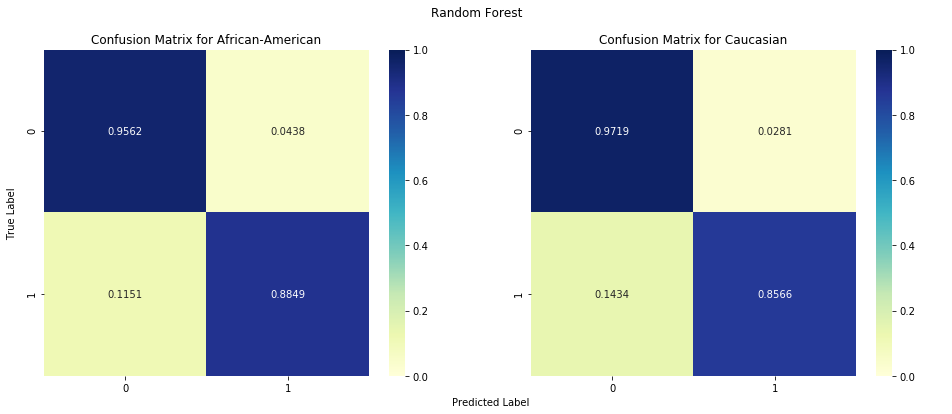

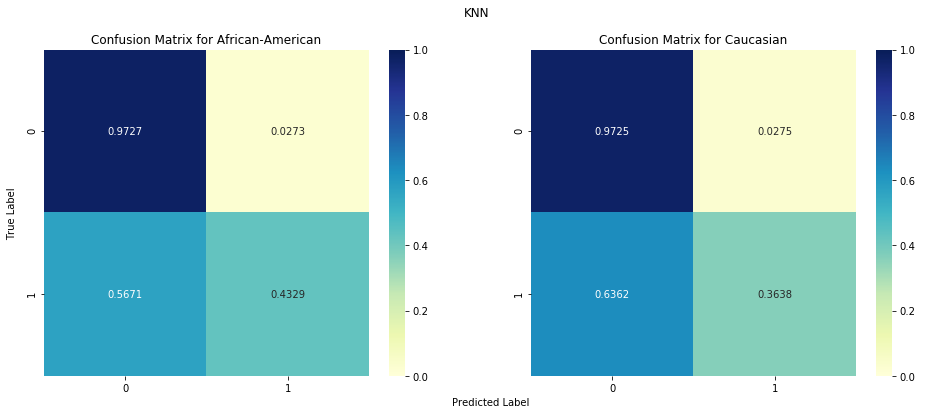

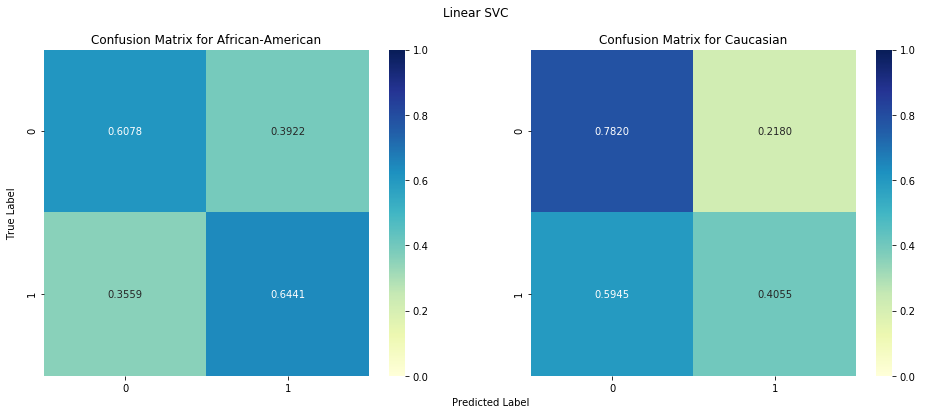

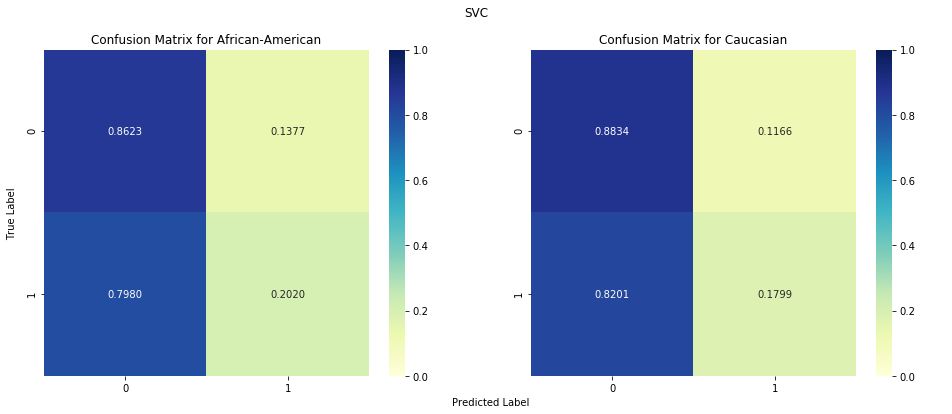

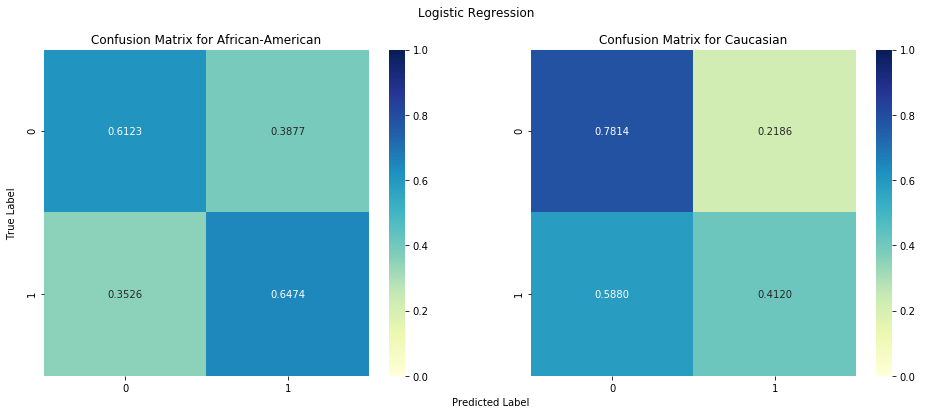

In [109]:
test_complete_dataset(data_compas_complete_X, data_compas_complete_y, data_compas_complete_protected, multi=True)